In [1]:
from prereqs import * ## imports wrapper functions such as plot, hist, and summary

now importing: 
1. numpy as np 
2. matplotlib.pyplot as plt
3. from scipy stats




## Introduction 



1. Monitoring Convergence using multiple MC experiments

2. Antithetic Variables




## Monitoring Convergence  

As a toy example, consider the simple function $h(x) = [cos(50x) + sine(50x)]^2$. Using a simple MC algorithm, we can estimate $\theta = \int_0^1 h(x)$. Let us generate $n$ samples $x_1, ..., x_n \sim Unif(0,1)$, such that $\displaystyle \theta = E[h(x)] \approx \frac{1}{n} \sum^n h(x_i)$. 



In [2]:
np.random.seed(456789) ## set seed
n = 10000
h = lambda x: ( np.cos(50*x) + np.sin(50*x) )**2
u = np.random.rand(n)

theta_est = cumMean(h(u))
se = cumSE(h(u))

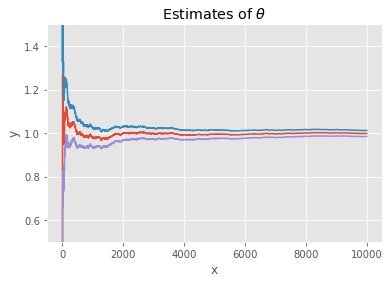

In [3]:
x = range(1, n+1)
plot(x, y = theta_est, show=False) ## don't automatically plot
plot(x, y = theta_est + 1.96*se, show=False) ## can also use plt.hlines function
plot(x, y = theta_est - 1.96*se, show=False)
plt.ylim(0.5, 1.5)
plt.title(r"Estimates of $\theta$")
plt.show()
u = np.random.rand(n)

theta_est = cumMean(h(u))
se = cumSE(h(u))

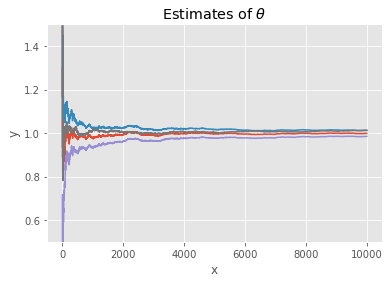

In [4]:
u2 = np.random.rand(n) ## new experiment

theta_est2 = cumMean(h(u2))  ## new experiment cumulative mean

x = range(1, n+1)
plot(x, y = theta_est, show=False) ## don't automatically plot
plot(x, y = theta_est + 1.96*se, show=False) ## can also use plt.hlines function
plot(x, y = theta_est - 1.96*se, show=False)
plot(x, y = cumMean(h(u2)), show=False)
plt.ylim(0.5, 1.5)
plt.title(r"Estimates of $\theta$")
plt.show()


If we now add a new experiment, the new sample is not guaranteed to stay within the 95% CI.


## Monitoring Convergence  


Monitoring convergence of Monte Carlo samples is important to assessing the quality of estimators. For some MC estimate $\theta_{MC}$, it is possible to run many parallel processes and graphically monitor how they converge, and from those samples obtain a confidence band. 

However, this may be computationally costly, and resource (e.g. hardware + time) intensive.

To understand how much memory our experiments are using, we can use the library [memory_profiler](https://pypi.python.org/pypi/memory_profiler). Many programming langugages have libraries for profiling code, and monitoring bottlenecks and resource consumption.

- To install: `pip install memory_profiler`
- Or in Anaconda: `conda install -c chroxvi memory_profiler` 




### IPython integration

After installing the module, if you use IPython, you can use the `%mprun`, `%%mprun`, `%memit` and `%%memit` magics.

For IPython 0.11+, you can use the module directly as an extension, with %load_ext memory_profiler

To activate it whenever you start IPython, edit the configuration file for your IPython profile, ~/.ipython/profile_default/ipython_config.py, to register the extension like this (If you already have other extensions, just add this one to the list):

    c.InteractiveShellApp.extensions = [
        'memory_profiler',
    ]


If the config file doesn’t already exist, run the command `ipython profile create` in a terminal (Windows CMD terminal, Linux terminal, or iOS terminal).



Then you should be able to run something simple like:

In [5]:
%memit

peak memory: 98.98 MiB, increment: 0.20 MiB



## Monitoring Convergence  

While running, monitor your computer's resource manager



In [6]:
## parallel monte carlo samples
M = 200
n = 10000
X = np.random.uniform(size = (n, M))
h_samples = h(X)


In [7]:
%memit X = np.random.uniform(size = (n, M))

peak memory: 144.82 MiB, increment: 15.14 MiB


In [8]:
## we'll need to apply cums down columns,
## so remember that:
beta = np.array([[1,2,3], [1,2,3], [1,2,3]])
print(beta)

[[1 2 3]
 [1 2 3]
 [1 2 3]]


In [9]:
np.cumsum(beta, axis = 0) ## sums down columns

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])

In [10]:
np.cumsum(beta, axis = 1) ## sums rows

array([[1, 3, 6],
       [1, 3, 6],
       [1, 3, 6]])

In [11]:
def cummean(matrix, axis = 0):
    n = matrix.shape[0]
    denom = np.array(range(1, n+1)).reshape(n, 1)
    return np.cumsum(matrix, axis = axis) / denom

In [12]:
#thetaEstimates = np.apply_along_axis(arr=h_samples, func1d = cumMean, axis = 1)
thetaEstimates = cummean(h_samples, axis = 0)

quantiles = lambda x: np.percentile(a=x, q=[2.5, 97.5]) ## get 2.5%, and 97.5% for Confidence Interval

parallelCI = np.percentile(thetaEstimates, q = [2.5, 97.5], axis = 1)
print(parallelCI.shape) ## return 2 rows, 10000 columns...numpy is strange!

print(np.mean(parallelCI[1])) ## upper bounds
print(np.mean(parallelCI[0]))  ## lower bounds


(2, 10000)
1.02767909471
0.974898115088


In [13]:
%memit thetaEstimates

peak memory: 175.40 MiB, increment: 0.02 MiB


In [14]:
parallelCI[:,0]

array([ 0.00284229,  1.99861253])

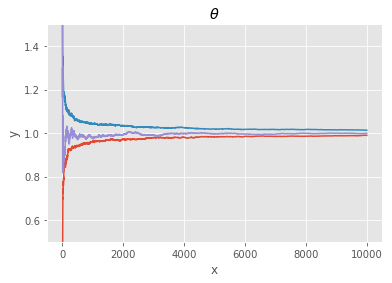

In [15]:
x = range(1, n+1)
fig, ax = plt.subplots() ## needed to add polygon
plot(x, parallelCI[0], show=False)
plot(x, parallelCI[1], show=False)
plot(x, theta_est, show=False)
plt.ylim(0.5, 1.5)
plt.title(r"$\theta$")
plt.show()

## Monitoring Convergence  

An approximate but cheaper version of this basic Monte Carlo estimate of the variability is to bootstrap the originally obtained samples and from there estimate a 95% confidence band.



## Monitoring Convergence | Bootstrap CI  




In [16]:
## bootstrap
ind = np.random.choice(a = range(n), size = n*M, replace=True) ## sample with replacement!
bootsamples = h(X[ind])

In [17]:
%memit

peak memory: 3147.92 MiB, increment: 0.68 MiB


In [18]:
bootestimates = cummean(h_samples, axis = 0)

bootquantiles = lambda x: np.percentile(a=x, q=[2.5, 97.5]) ## get 2.5%, and 97.5% for Confidence Interval

bootCI = np.percentile(thetaEstimates, q = [2.5, 97.5], axis = 1)
print(bootCI.shape) ## return 2 rows, 10000 columns...numpy is strange!

print(np.mean(bootCI[1])) ## upper bounds
print(np.mean(bootCI[0]))  ## lower bounds


(2, 10000)
1.02767909471
0.974898115088


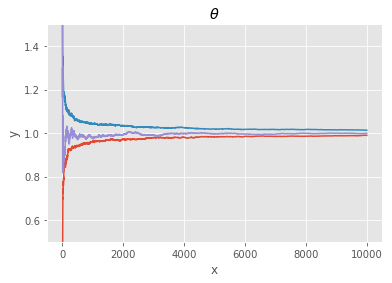

In [19]:
x = range(1, n+1)
fig, ax = plt.subplots() ## needed to add polygon
plot(x, bootCI[0], show=False)
plot(x, bootCI[1], show=False)
plot(x, theta_est, show=False)
plt.ylim(0.5, 1.5)
plt.title(r"$\theta$")
plt.show()




## Antithetic Variables   

In previous experiments, when we've worked to generate pseudo-random samples from distributions, we've worked with *iid* (independent and identically distributed) peuso-random samples from an instrumental distribution. 

Generally, *iid* samples are always preferable, but not always cost efficient. As problems become more complicated, generating random samples from a target distribution will become more cumbersome and time/resource consuming. 

Therefore, in this section we will present methods in which we can double down on our generated samples to speed up convergence and utilize more of our available resources.


## Antithetic Variables   

Suppose we are interested in estimating a parameter $\theta$ and we have two unbiased estimators $X$ and $Y$ with finite variances $\sigma^2_X = \sigma^2_Y = \sigma^2$. The average of the two unbiased estimators is also an unbiased estimator, $Z = (X + Y) / 2$. Given $X, Y$ and $Z$ are all unbiased, we can compare them using their variances and choose the smallest of the three. 

The variance for $Z$ is given by 
$$
\begin{aligned}
Var(Z) & =  Var(\frac{X + Y}{2})  = \left(\frac{1}{2} \right)^2 \times Var(X + Y) \\
\ & = \frac{1}{4} \left(  Var(X) + Var(Y) + 2 Cov(X, Y) \right) \\
\ & = \frac{1}{4} Var(X) + \frac{1}{4} Var(Y) + \frac{1}{2} Cov(X, Y) \\
\ & = \frac{1}{4} \sigma^2 + \frac{1}{4} \sigma^2 + \frac{1}{2} Cov(X, Y) \\
\ & = \frac{1}{2} (\sigma^2 +  Cov(X, Y))
\end{aligned}
$$

If $Cov(X, Y) < 0$ (or $Cor(X, Y) < 0$), then $Var(Z) < \sigma^2$, therefore, $Z$ would perform better as an unbiased estimator. In this scenario, $X$ and $Y$ would be *antithetic* to each other; thus they are *antithetic variables*.


## Antithetic Variables   

The Monte Carlo integration estimator
$$
\begin{aligned}
\theta & = \displaystyle \int_{- \infty}^{\infty} h(x) f(x) dx \\
\end{aligned}
$$
Let $X$ and $Y$ denote random samples, $x_1, ..., x_n$ and $y_1, ..., y_n$, respectively. If $X$ and $Y$ are negatively correlated, then the estimator $\hat{\theta}$ of $\theta$
$$
\begin{aligned}
\hat{\theta} & = \displaystyle \frac{1}{2n} \sum_{i = 1}^{n} [h(x_i) + h(y_i)] \\
\end{aligned}
$$
is more efficient than the estimator $\displaystyle \hat{\theta} = \frac{1}{2n} \sum_{i = 1}^{2n} h(x_i)$. The random variables $X$ and $Y$ are then called *antithetic variables*. 




## Antithetic Variables   

Albeit useful, this method is not always possible. For arbitrary transformations $h(.)$, it is not always possible to generate negatively correlations $X$ and $Y$.

As covered in the introduction, we can generate negatively correlated samples from a uniform distribution.

Consider the following. Let $h(x) = e^x$, where we'd like to solve $\int_0^1 h(x) dx$.
We can take this problem as

$$
\theta = \int_0^1 h(x) dx = \int_0^1 h(x) f(x) dx
$$
where $f(x) = 1$ for a $Unif(0,1)$ distribution. Then




In [20]:
n = 50000
u = np.random.rand(n)

h = lambda x: np.exp(x)

thetaHat = np.mean(h(u))
print(thetaHat)



1.71779204827


In [21]:

from scipy.integrate import quad
print(quad(h, 0, 1)) ## return estimate and error

(1.7182818284590453, 1.9076760487502457e-14)


In [22]:
## using antithetic variables

u1 = np.random.uniform(size = int(n/2))
u2 = 1 - u1

thetaHatAV = np.mean([h(u1), h(u2)])
print(thetaHatAV)


1.71798578513


In [23]:
from scipy import stats

stats.pearsonr(x=h(u1), y = h(u2)) ## correlation nearly -1

(-0.96788472733055786, 0.0)

## Exercise   

Suppose $X \sim N(0,1)$ and we wish to estimate $\theta = E[h(X)]$ where $h(X) = \frac{x}{(2^x - 1)}$. 

By regular Monte Carlo estimation, we can estimate $\theta$ with $n = 10^6$ samples from $N(0,1)$. 

By antithetic variable estimation we can estimate $\theta$ by $m = n/2 = 50,000$. Construct an antithetic sample where $Cor(-X, X) = -1$. 

Compare your results with regular MC estimation.







# Appendix   




In [24]:
n = 10**6
m = int(n/2)

h = lambda x: x/(2**x - 1)  ## anonymous function

y = np.random.normal(size = n)
theta_MC = np.mean(h(y))

w = np.random.normal(size = m)
theta_AS = np.sum([h(w) + h(-1 * w)]) / n

print(theta_MC)
print(theta_AS)

1.49868732676
1.49907797151


In [25]:
## standard errors
rho,_ = stats.pearsonr(x = h(w), y = h(-w))
seAnti = (1+rho)*np.var(h(w))/n

print(rho)
print(seAnti)

-0.952023825215
1.22981354255e-08
